In [1]:
#
#   Testing MOCO methods
#   

In [2]:
# imports (using the 'moco_repair' branch of GCE)
import time
import os
import json
import hashlib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gcamp_extractor import MultiFileTiff
from gcamp_extractor.moco import compute_moco_offsets
from gcamp_extractor.moco import view_moco_offsets

In [3]:
# LOAD DATA

## test case worms, can be found on YAKALO NAS under /yakalo/share/jackson/
ykroot = '/media/gbubnis/Extreme SSD/yakalo/jackson'
#root = ykroot+'/2021-07-21/worm15_act1'  # cat 2, some X drift
#root = ykroot+'/2021-07-30/worm04_act1'  # steady-ish X drift
root = ykroot+'/2021-07-30/worm06_act1'  # nassty! head casting (rotation) and drift
#root = ykroot+'/2021-07-31/worm01_act1'  # still.. then X drift + joystick correction

params_mft = {
    'root':os.path.join(root, 'GCAMP'),
    'numz':12,
    'numc':1,
}

with open(os.path.join(root, 'info.json')) as f:
    infodict = json.load(f)

dwa = '%s_worm%02i_act%s' % (infodict['date'], int(infodict['worm']), infodict['act'])
print(dwa)

# GROUND TRUTH: cumulative X,Y offsets for first 500 vols
ground_truth = {
    '2021-07-21_worm15_act1':[-32, -2],
    '2021-07-30_worm04_act1':[-108, 0],
    '2021-07-30_worm06_act1':[162, -10],
    '2021-07-31_worm01_act1':[273,18], # still some visible jitter for some frames
}

output_dir = os.path.join('mocotest_'+ dwa)
os.makedirs(output_dir, exist_ok=True)
mft = MultiFileTiff(output_dir=output_dir, **params_mft)

2021-07-30_worm06_act1


In [4]:
# make param dicts
p0 = dict(mode_2D='mid', median=0, gaussian=0, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p1 = dict(mode_2D='mid', median=3, gaussian=0, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p2 = dict(mode_2D='mid', median=5, gaussian=0, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p3 = dict(mode_2D='mid', median=5, gaussian=2, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p4 = dict(mode_2D='mid', median=5, gaussian=4, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)

p5 = dict(mode_2D='mid', median=0, gaussian=0, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)
p6 = dict(mode_2D='mid', median=3, gaussian=0, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)
p7 = dict(mode_2D='mid', median=5, gaussian=0, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)
p8 = dict(mode_2D='mid', median=5, gaussian=2, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)
p9 = dict(mode_2D='mid', median=5, gaussian=4, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)

p10 = dict(mode_2D='mid', median=0, gaussian=2, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p11 = dict(mode_2D='mid', median=3, gaussian=2, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p12 = dict(mode_2D='mid', median=5, gaussian=2, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p13 = dict(mode_2D='mid', median=3, gaussian=4, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p14 = dict(mode_2D='mid', median=5, gaussian=4, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)

todo = [p0, p1, p2, p3, p4,   p5, p6, p7, p8, p9, p10, p11, p12, p13, p14]

df_todo = pd.DataFrame(todo)
df_todo.head(20)

,mode_2D,median,gaussian,method,ird_filter_pcorr,upsample_factor,t_max
0,mid,0,0,ird,0,0,500
1,mid,3,0,ird,0,0,500
2,mid,5,0,ird,0,0,500
3,mid,5,2,ird,0,0,500
4,mid,5,4,ird,0,0,500
5,mid,0,0,skimage,0,10,500
6,mid,3,0,skimage,0,10,500
7,mid,5,0,skimage,0,10,500
8,mid,5,2,skimage,0,10,500
9,mid,5,4,skimage,0,10,500


In [5]:
# compute offsets and dump to file, allowing re-load to avoid slow re-compute

def get_offsets(mft, params):
    """pack up params and compute offsets"""
    filter_keys = ['median', 'gaussian']
    other_keys = ['method', 'ird_filter_pcorr', 'upsample_factor', 't_max', 'mode_2D']
    flt = {k:params[k] for k in filter_keys}
    oth = {k:params[k] for k in other_keys}
    offsets = compute_moco_offsets(mft=mft, filter_params=flt, **oth)
    return offsets

all_offsets = []
for p in todo:
    # hash the params+data source to get a unique filename for the computed offset 
    xxx = json.dumps(p, sort_keys=True)+root
    hash8 = hashlib.sha224(str(xxx).encode('utf-8')).hexdigest()[-8:]
    datafile = os.path.join(output_dir, 'data-%s.pk' % hash8)

    tag = 'med/gauss/method/file: %-18s %s' % (str([p['median'], p['gaussian'], p['method']]),  datafile)
    if os.path.isfile(datafile):
        # already run
        print('load:', tag)
        with open(datafile,'rb') as f:
            [p, offsets] = pickle.load(f)
    else:
        # not yet run run
        print('calc:', tag)
        t00 = time.time()
        offsets = get_offsets(mft, p)
        t01 = time.time()
        print('runtime [s]:', (t01-t00)//1)
        file_pi = open(datafile, 'wb')
        pickle.dump([p, offsets], file_pi)
        file_pi.close()

    all_offsets.append(offsets)

load: med/gauss/method/file: [0, 0, 'ird']      mocotest_2021-07-30_worm06_act1/data-7182122d.pk
load: med/gauss/method/file: [3, 0, 'ird']      mocotest_2021-07-30_worm06_act1/data-a666744c.pk
load: med/gauss/method/file: [5, 0, 'ird']      mocotest_2021-07-30_worm06_act1/data-788081f3.pk
load: med/gauss/method/file: [5, 2, 'ird']      mocotest_2021-07-30_worm06_act1/data-6c2dda41.pk
load: med/gauss/method/file: [5, 4, 'ird']      mocotest_2021-07-30_worm06_act1/data-08feeefb.pk
load: med/gauss/method/file: [0, 0, 'skimage']  mocotest_2021-07-30_worm06_act1/data-b80f2f7b.pk
load: med/gauss/method/file: [3, 0, 'skimage']  mocotest_2021-07-30_worm06_act1/data-8ee1edad.pk
load: med/gauss/method/file: [5, 0, 'skimage']  mocotest_2021-07-30_worm06_act1/data-af66c1f5.pk
load: med/gauss/method/file: [5, 2, 'skimage']  mocotest_2021-07-30_worm06_act1/data-99c802ad.pk
load: med/gauss/method/file: [5, 4, 'skimage']  mocotest_2021-07-30_worm06_act1/data-0d92d1ec.pk
load: med/gauss/method/file: [

y stretch!


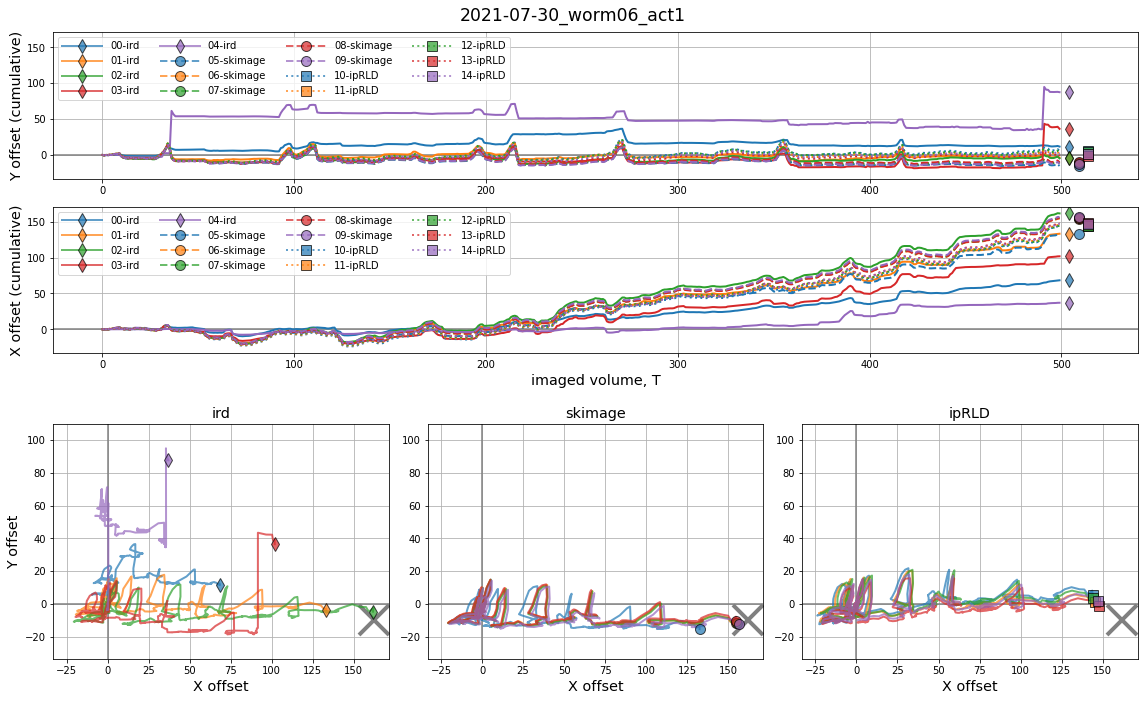

In [6]:
# plot offset timeseries
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']*10

fig = plt.figure(figsize=(16, 10))

axs = [plt.subplot(4,3,(1,3))]
axs.append(plt.subplot(4,3,(4,6), sharex=axs[0], sharey=axs[0]))
axs.append(plt.subplot(4,3,(7,10)))
axs.append(plt.subplot(4,3,(8,11), sharex=axs[2], sharey=axs[2]))
axs.append(plt.subplot(4,3,(9,12), sharex=axs[2], sharey=axs[2]))

axs[0].axhline(y=0, color='grey')
axs[1].axhline(y=0, color='grey')
axs[2].axhline(y=0, color='grey')
axs[2].axvline(x=0, color='grey')
axs[2].set_aspect('equal')
axs[3].axhline(y=0, color='grey')
axs[3].axvline(x=0, color='grey')
axs[3].set_aspect('equal')
axs[4].axhline(y=0, color='grey')
axs[4].axvline(x=0, color='grey')
axs[4].set_aspect('equal')


p['ird']     = dict(ls='-',  marker='d', _counter=0, panel2d=2, dt=5)
p['skimage'] = dict(ls='--', marker='o', _counter=0, panel2d=3, dt=10)
p['ipRLD']   = dict(ls=':',  marker='s', _counter=0, panel2d=4, dt=15)

# plot ground truth X markers
try:
    gtxy = ground_truth[dwa]
    axs[2].plot(gtxy[0], gtxy[1], 'x', color='k', mec='grey', mew=4, ms=30)
    axs[3].plot(gtxy[0], gtxy[1], 'x', color='k', mec='grey', mew=4, ms=30)
    axs[4].plot(gtxy[0], gtxy[1], 'x', color='k', mec='grey', mew=4, ms=30)
except:
    pass


for i, (params, offsets) in enumerate(zip(todo, all_offsets)):
    lbl = '%2.2i-%s' % (i, params['method'])
    tt = range(len(offsets))
    yy = np.cumsum(offsets[:,1])
    xx = np.cumsum(offsets[:,2])
    pp = p[params['method']]
    color = colors[pp['_counter']]

    # timeseries
    axs[0].plot(tt, -yy, ls=pp['ls'], color=color, lw=2)
    axs[1].plot(tt, -xx, ls=pp['ls'], color=color, lw=2)
    axs[0].plot(tt[-1]+pp['dt'], -yy[-1], marker=pp['marker'], ls=pp['ls'], color=color, mec='k', ms=10, lw=2, label=lbl, alpha=0.7)
    axs[1].plot(tt[-1]+pp['dt'], -xx[-1], marker=pp['marker'], ls=pp['ls'], color=color, mec='k', ms=10, lw=2, label=lbl, alpha=0.7)
    
    # 2d translation
    axs[pp['panel2d']].plot(-xx, -yy, label=lbl, color=color, lw=2, alpha=0.7)
    axs[pp['panel2d']].plot(-xx[-1], -yy[-1], marker=pp['marker'], ls=pp['ls'], color=color, mec='k', ms=10, lw=2, label=lbl, zorder=3, alpha=0.7)
    
    # color index counter
    pp['_counter'] += 1


# formatting        
axs[0].legend(fontsize='medium', ncol=4, handlelength=4)
axs[0].grid()
axs[0].set_ylabel('Y offset (cumulative)', fontsize='x-large')

axs[1].legend(fontsize='medium', ncol=4, handlelength=4)
axs[1].grid()
axs[1].set_ylabel('X offset (cumulative)', fontsize='x-large')
axs[1].set_xlabel('imaged volume, T', fontsize='x-large')

axs[2].set_xlabel('X offset', fontsize='x-large')
axs[2].set_ylabel('Y offset', fontsize='x-large')
axs[2].grid()
axs[2].set_title('ird', fontsize='x-large')

axs[3].set_xlabel('X offset', fontsize='x-large')
axs[3].grid()
axs[3].set_title('skimage', fontsize='x-large')

axs[4].set_xlabel('X offset', fontsize='x-large')
axs[4].grid()
axs[4].set_title('ipRLD', fontsize='x-large')


# stretch 2D plots if they are too flat
ylim = axs[2].get_ylim()
xlim = axs[2].get_xlim()
if np.diff(ylim)/np.diff(xlim)<0.7:
    print('y stretch!')
    dy = (np.diff(xlim)*0.7 - np.diff(ylim))/2
    axs[2].set_ylim((ylim[0]-dy, ylim[1]+dy))
    
fig.suptitle(dwa, fontsize='xx-large')
fig.tight_layout()

In [7]:
# view one case in napari (to decide what is closest to ground truth)
view_moco_offsets(mft, all_offsets[6])